# No PVC - only local disk

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean',
        'Latency Distribution.99th Percentile Latency (microseconds)': 'max',
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpcc_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [5]:
codes = ['1750956047', '1750957727', '1750959412', '1750961088', '1750962809', '1750964529', '1750966420', '1750968232', '1750970079', '1750972038', '1750973923', '1750975831', '1750977897', '1750979870', '1750981727', '1750983880', '1750985921', '1750987946', '1750990114', '1750992266', '1750994292', '1750996702', '1750998931', '1751001062', '1751003657', '1751005982', '1751008063', '1751010748', '1751013150', '1751015378']
# '1750949971', 
codes

['1750956047',
 '1750957727',
 '1750959412',
 '1750961088',
 '1750962809',
 '1750964529',
 '1750966420',
 '1750968232',
 '1750970079',
 '1750972038',
 '1750973923',
 '1750975831',
 '1750977897',
 '1750979870',
 '1750981727',
 '1750983880',
 '1750985921',
 '1750987946',
 '1750990114',
 '1750992266',
 '1750994292',
 '1750996702',
 '1750998931',
 '1751001062',
 '1751003657',
 '1751005982',
 '1751008063',
 '1751010748',
 '1751013150',
 '1751015378']

In [6]:
df_performance = get_performance_all_single(codes)
df_performance

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds),type,num_tenants
connection_pod,,,,,,,,,,,,,,,,,,,,,
PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536,1,1,lmh4z.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2241822,55686,733,20020,113084,233126,92007,61526,schema,1
PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536,1,2,rrr4s.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1989243,20191,776,13932,55161,120050,33499,27644,schema,1
PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536,1,1,hmsfc.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,3269385,48591,700,19072,130994,336237,95248,65703,database,1
PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536,1,2,thrpj.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2024409,20791,785,14100,56072,121875,34379,28233,database,1
PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0,1,1,6bqtc.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2644758,57999,759,21667,118432,311428,91916,65801,container,1
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,ckzmk.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1055428,19834,814,13651,51128,110389,31914,26271,container,1
PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536,1,1,tmcfh.dbmsbenchmarker,2,tpcc,postgres,65536,600,...,7837759,86972,744,32877,199927,731973,145380,112399,schema,2
PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536,1,1,6bckt.dbmsbenchmarker,2,tpcc,postgres,65536,600,...,5624816,82884,787,33367,193982,661834,140664,107613,schema,2
PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536,1,2,vpsmq.dbmsbenchmarker,2,tpcc,postgres,65536,600,...,1115641,33035,758,18394,93886,161606,61851,44286,schema,2


In [7]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

connection           configuration  \
num_tenants type                                                          
1           schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
2           schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
3           schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
4           schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            schema       PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-1    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-1-1-65536   
            database     PostgreSQL-1-1-65536-2    PostgreSQL-

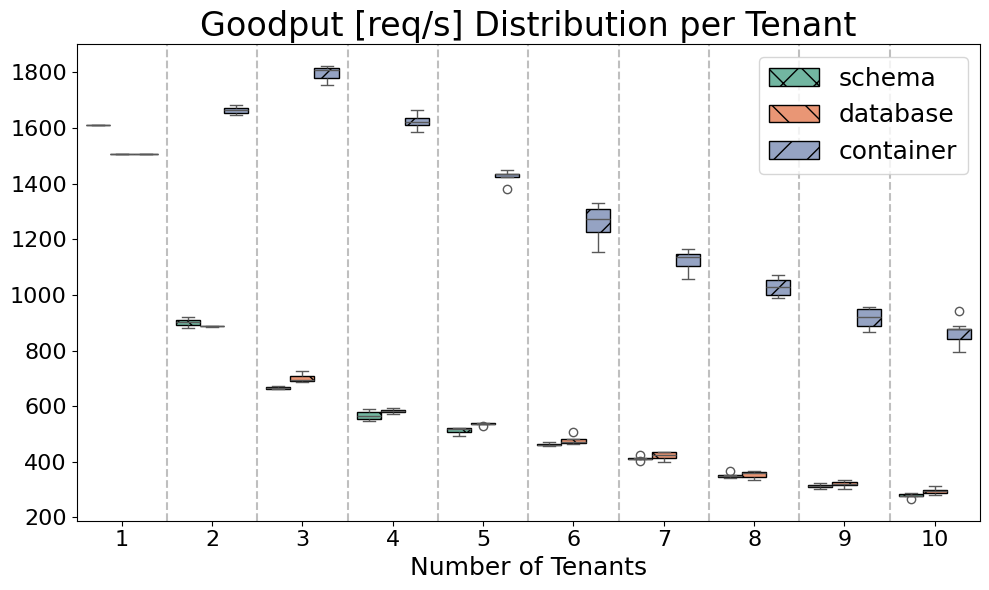

In [8]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()

plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Goodput (requests/second)',
    hue='type',
    palette='Set2'  # consistent colors per type
)
# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = "Goodput [req/s] Distribution per Tenant"
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpcc_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

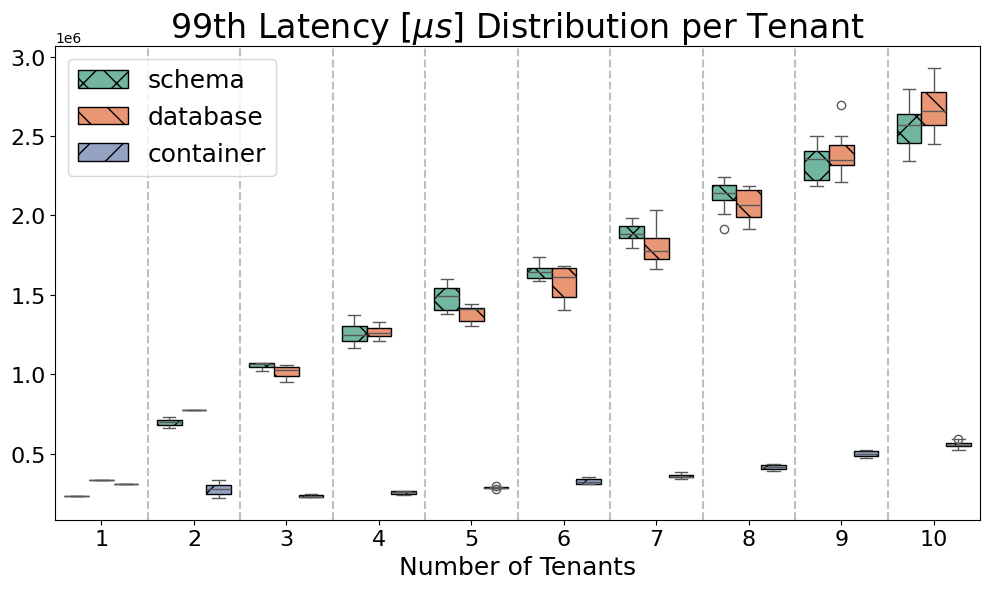

In [9]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()

plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Latency Distribution.99th Percentile Latency (microseconds)',
    hue='type',
    palette='Set2'  # consistent colors per type
)
# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = "99th Latency [$\mu s$] Distribution per Tenant"
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpcc_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

In [10]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants
0,1,1609.803135,8,61526.000000,233126,schema,1
1,2,3566.358241,44,27644.000000,120050,schema,1
0,1,1507.044943,11,65703.000000,336237,database,1
1,2,3492.439757,59,28233.000000,121875,database,1
0,1,1505.636592,8,65801.000000,311428,container,1
1,2,3751.173174,48,26271.000000,110389,container,1
0,1,1803.913142,9,110006.000000,731973,schema,2
1,2,4441.248082,44,44493.000000,170974,schema,2
0,1,1776.644935,8,111629.000000,777771,database,2
1,2,4597.371346,48,42984.500000,157177,database,2


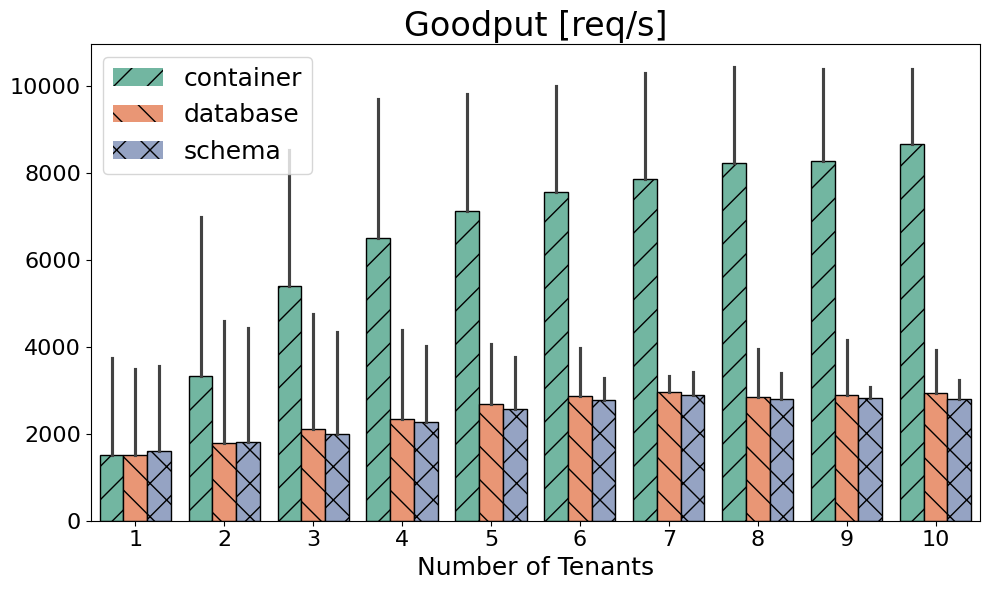

In [11]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

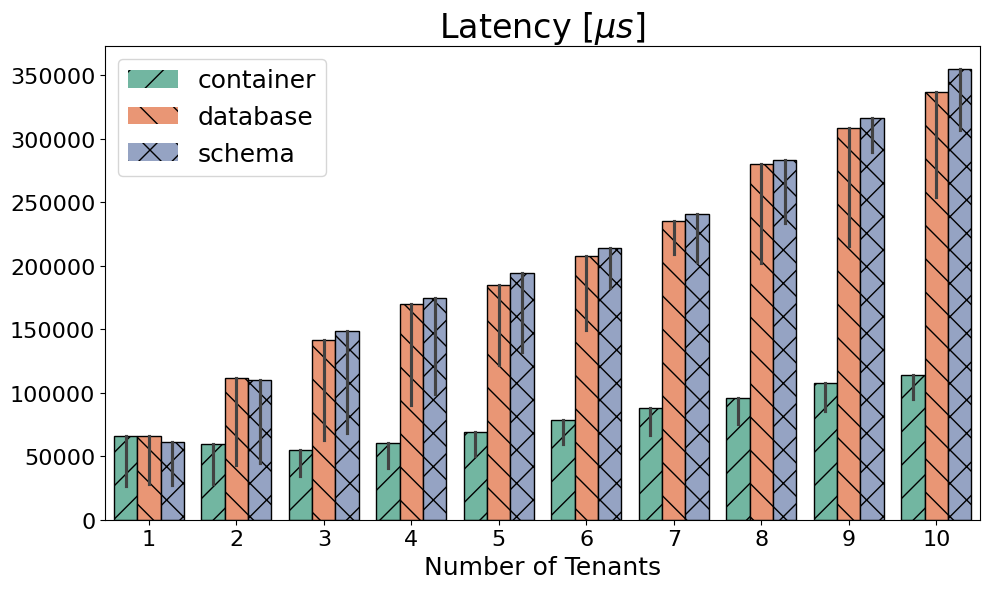

In [12]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

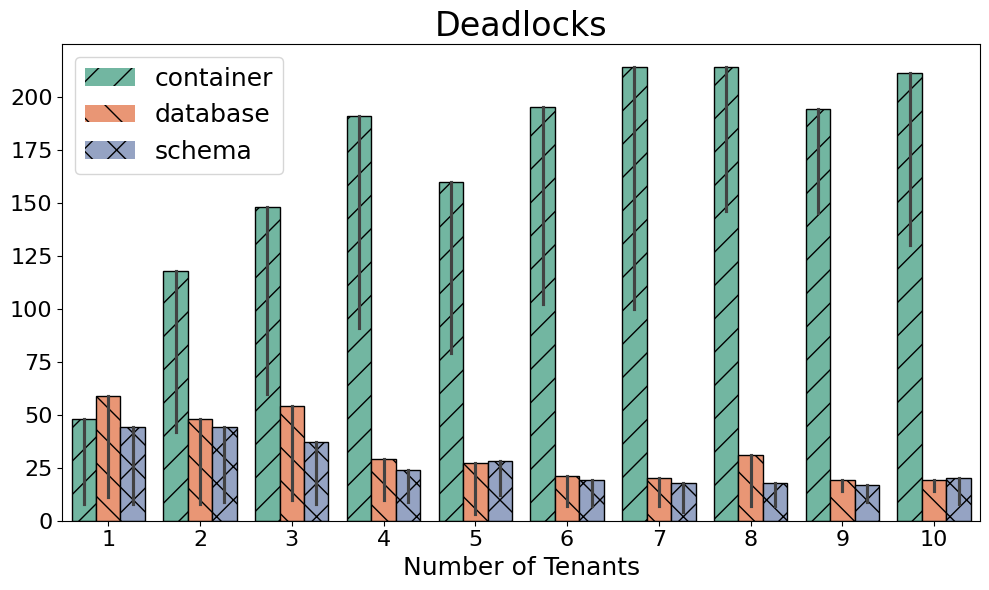

In [13]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [14]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-1-1-65536-1,259.0,102.0,157.0,1,1,,1,2720,schema,1
PostgreSQL-1-1-65536-2,259.0,102.0,157.0,1,1,,2,6321,schema,1
PostgreSQL-1-1-65536-1,255.0,96.0,159.0,1,1,,1,2738,database,1
PostgreSQL-1-1-65536-2,255.0,96.0,159.0,1,1,,2,6170,database,1
PostgreSQL-1-1-65536-0-1,252.0,95.0,157.0,1,1,0,1,2720,container,1
PostgreSQL-1-1-65536-0-2,252.0,95.0,157.0,1,1,0,2,6151,container,1
PostgreSQL-1-1-65536-1,323.0,131.0,191.0,1,2,,1,5417,schema,2
PostgreSQL-1-1-65536-2,323.0,131.0,191.0,1,2,,2,9782,schema,2
PostgreSQL-1-1-65536-1,330.0,137.0,192.0,1,2,,1,5438,database,2
PostgreSQL-1-1-65536-2,330.0,137.0,192.0,1,2,,2,9740,database,2


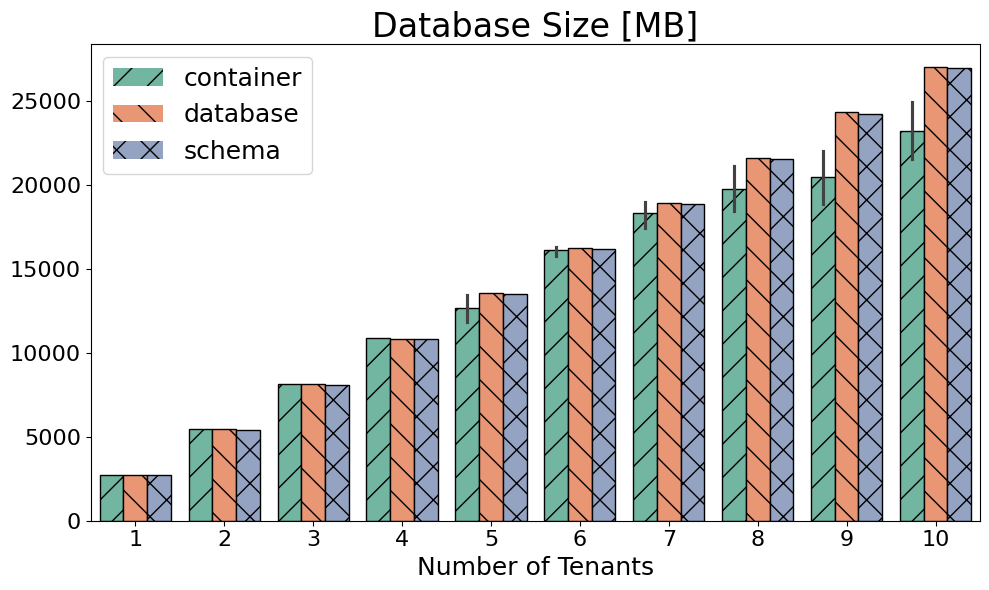

In [15]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

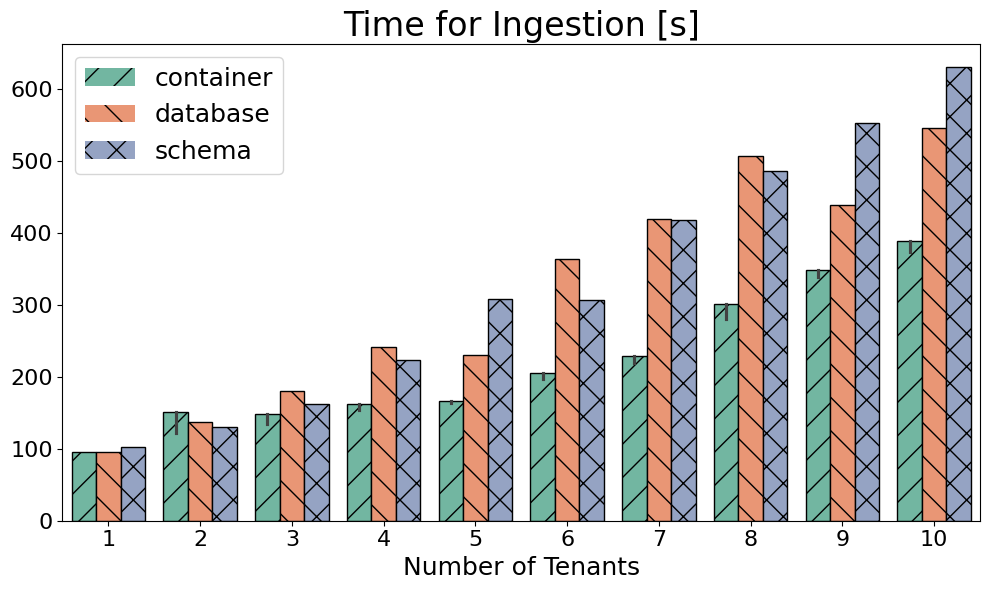

In [16]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

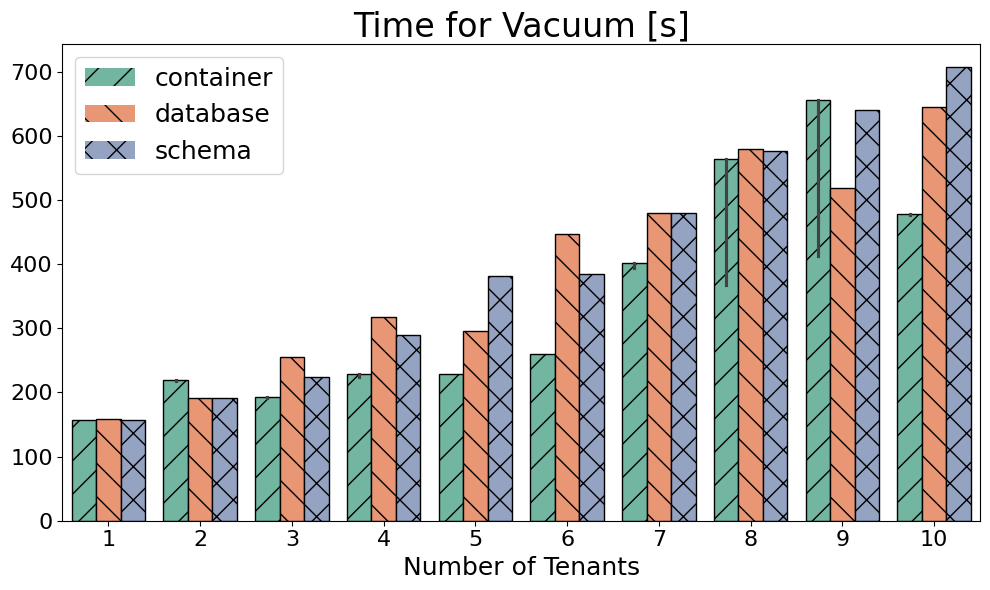

In [17]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

In [18]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,8295.98,5.22,7.09,18.08,schema,1
0,1,8099.91,5.22,7.08,20.93,database,1
0,1,7932.49,5.18,7.02,16.62,container,1
0,1,10132.37,7.86,11.01,16.65,schema,2
0,1,9605.15,7.92,11.08,21.43,database,2
0,1,18419.05,10.54,14.15,39.06,container,2
0,1,11515.29,10.63,14.94,31.88,schema,3
0,1,11308.67,10.76,15.17,21.96,database,3
0,1,28321.29,16.05,21.13,49.70,container,3
0,1,13469.14,13.74,19.31,31.72,schema,4


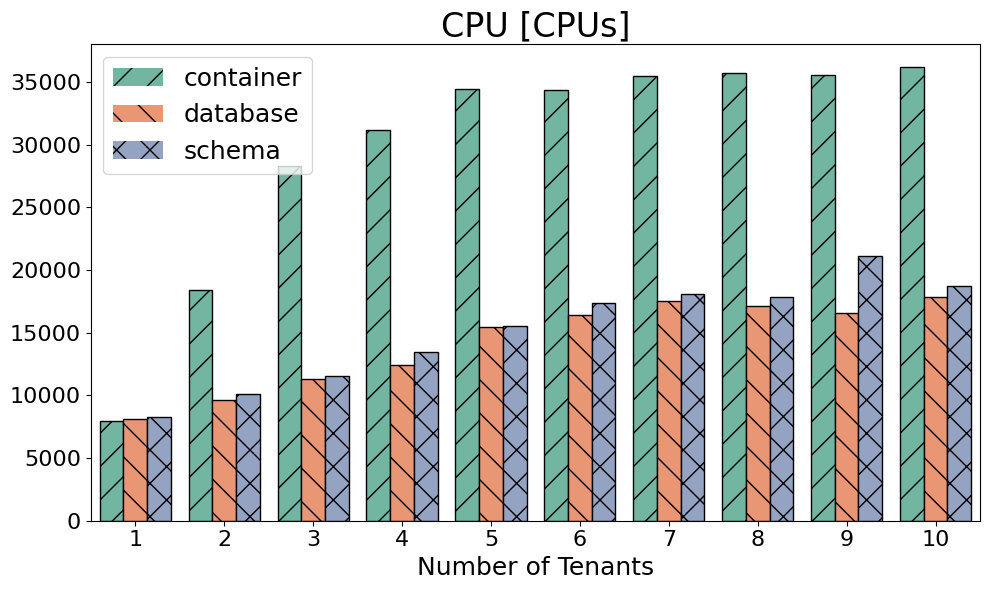

In [19]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

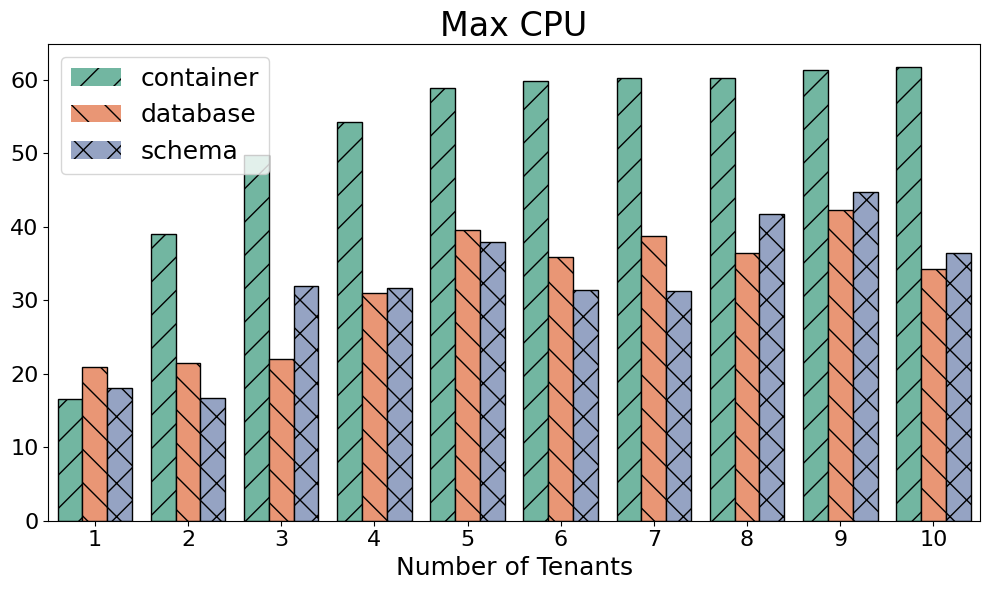

In [20]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

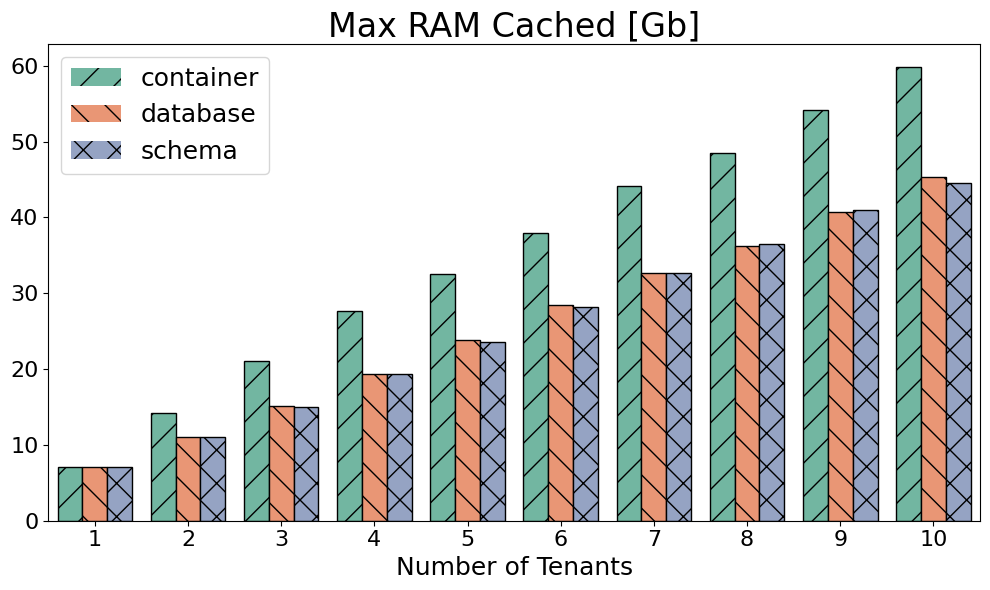

In [21]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Single Experiment

In [22]:
code = '1751015378'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [23]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

connection_pod,PostgreSQL-1-1-65536-8-1-1,PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-7-1-1,PostgreSQL-1-1-65536-2-1-1,PostgreSQL-1-1-65536-9-1-1,PostgreSQL-1-1-65536-4-1-1,PostgreSQL-1-1-65536-6-1-1,PostgreSQL-1-1-65536-5-1-1,PostgreSQL-1-1-65536-3-1-1,PostgreSQL-1-1-65536-2-2-1,PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-8-2-1,PostgreSQL-1-1-65536-5-2-1,PostgreSQL-1-1-65536-9-2-1,PostgreSQL-1-1-65536-6-2-1,PostgreSQL-1-1-65536-4-2-1,PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-7-2-1,PostgreSQL-1-1-65536-3-2-1
connection,PostgreSQL-1-1-65536-8-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-7-1,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-9-1,PostgreSQL-1-1-65536-4-1,PostgreSQL-1-1-65536-6-1,PostgreSQL-1-1-65536-5-1,PostgreSQL-1-1-65536-3-1,PostgreSQL-1-1-65536-2-2,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-8-2,PostgreSQL-1-1-65536-5-2,PostgreSQL-1-1-65536-9-2,PostgreSQL-1-1-65536-6-2,PostgreSQL-1-1-65536-4-2,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-7-2,PostgreSQL-1-1-65536-3-2
configuration,PostgreSQL-1-1-65536-8,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-7,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-9,PostgreSQL-1-1-65536-4,PostgreSQL-1-1-65536-6,PostgreSQL-1-1-65536-5,PostgreSQL-1-1-65536-3,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-8,PostgreSQL-1-1-65536-5,PostgreSQL-1-1-65536-9,PostgreSQL-1-1-65536-6,PostgreSQL-1-1-65536-4,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-7,PostgreSQL-1-1-65536-3
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2
pod,p5qmz.dbmsbenchmarker,p46kb.dbmsbenchmarker,t2tpw.dbmsbenchmarker,72qmn.dbmsbenchmarker,492g4.dbmsbenchmarker,tw5p9.dbmsbenchmarker,tzjh9.dbmsbenchmarker,fct55.dbmsbenchmarker,dwz8s.dbmsbenchmarker,2gjrf.dbmsbenchmarker,pvj8r.dbmsbenchmarker,lhgvk.dbmsbenchmarker,4b72j.dbmsbenchmarker,f645z.dbmsbenchmarker,bnvrz.dbmsbenchmarker,g828w.dbmsbenchmarker,vscb9.dbmsbenchmarker,bcs6d.dbmsbenchmarker,ss98d.dbmsbenchmarker,rxkzg.dbmsbenchmarker
pod_count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536
time,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600


In [24]:
get_loading_time_max(evaluation)

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk
PostgreSQL-1-1-65536-0-1,847.0,371.0,475.0,1,1,0,1,1888
PostgreSQL-1-1-65536-0-2,847.0,371.0,475.0,1,1,0,2,4726
PostgreSQL-1-1-65536-1-1,825.0,351.0,474.0,1,1,1,1,2016
PostgreSQL-1-1-65536-1-2,825.0,351.0,474.0,1,1,1,2,4624
PostgreSQL-1-1-65536-2-1,829.0,354.0,475.0,1,1,2,1,2080
PostgreSQL-1-1-65536-2-2,829.0,354.0,475.0,1,1,2,2,4846
PostgreSQL-1-1-65536-3-1,848.0,374.0,474.0,1,1,3,1,2112
PostgreSQL-1-1-65536-3-2,848.0,374.0,474.0,1,1,3,2,4744
PostgreSQL-1-1-65536-4-1,841.0,367.0,474.0,1,1,4,1,2272
PostgreSQL-1-1-65536-4-2,841.0,367.0,474.0,1,1,4,2,4503


In [25]:
get_monitoring_stream_single(evaluation).sort_values('client')

,CPU [CPUs],Max CPU,Max RAM [Gb],Max RAM Cached [Gb],client
PostgreSQL-1-1-65536-0-1,3569.72,6.17,4.82,6.01,1
PostgreSQL-1-1-65536-1-1,3522.88,6.12,4.78,5.96,1
PostgreSQL-1-1-65536-8-1,3661.56,6.20,4.82,6.01,1
PostgreSQL-1-1-65536-2-1,3810.24,6.46,4.83,6.04,1
PostgreSQL-1-1-65536-3-1,3609.86,6.18,4.83,6.02,1
PostgreSQL-1-1-65536-7-1,3513.05,5.97,4.75,5.94,1
PostgreSQL-1-1-65536-4-1,3557.11,6.02,4.72,5.90,1
PostgreSQL-1-1-65536-9-1,3631.87,6.14,4.77,5.97,1
PostgreSQL-1-1-65536-5-1,3619.20,6.26,4.79,5.99,1
PostgreSQL-1-1-65536-6-1,3701.76,6.22,4.78,6.00,1


In [26]:
get_monitoring_stream(evaluation)

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,1,36197.25,47.89,59.84,61.74
1,2,35524.77,53.63,67.59,59.78


## Efficiency

In [27]:
df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == '2']
df_performance_monitoring

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
1,2,12617.86,7.46,11.14,21.51,schema,1
1,2,12314.01,7.37,10.99,21.49,database,1
1,2,12591.02,7.35,11.13,21.38,container,1
1,2,17548.40,10.87,16.17,34.78,schema,2
1,2,16066.32,11.05,16.46,34.17,database,2
1,2,22983.57,14.66,21.01,39.51,container,2
1,2,17185.58,14.02,20.61,39.26,schema,3
1,2,17711.61,14.21,20.94,39.01,database,3
1,2,27784.95,21.04,28.29,47.10,container,3
1,2,18924.13,16.76,24.33,43.84,schema,4


In [28]:
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == '2']
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants
1,2,3566.358241,44,27644.000000,120050,schema,1
1,2,3492.439757,59,28233.000000,121875,database,1
1,2,3751.173174,48,26271.000000,110389,container,1
1,2,4441.248082,44,44493.000000,170974,schema,2
1,2,4597.371346,48,42984.500000,157177,database,2
1,2,6993.226286,118,28196.000000,125051,container,2
1,2,4333.458057,37,68492.000000,264100,schema,3
1,2,4748.354823,54,62545.666667,267435,database,3
1,2,8520.776132,148,34676.666667,147900,container,3
1,2,4007.228143,24,98843.750000,407453,schema,4


In [29]:
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,2,3566.358241,44,27644.000000,120050,schema,1,2,12617.86,7.46,11.14,21.51
1,2,3492.439757,59,28233.000000,121875,database,1,2,12314.01,7.37,10.99,21.49
2,2,3751.173174,48,26271.000000,110389,container,1,2,12591.02,7.35,11.13,21.38
3,2,4441.248082,44,44493.000000,170974,schema,2,2,17548.40,10.87,16.17,34.78
4,2,4597.371346,48,42984.500000,157177,database,2,2,16066.32,11.05,16.46,34.17
5,2,6993.226286,118,28196.000000,125051,container,2,2,22983.57,14.66,21.01,39.51
6,2,4333.458057,37,68492.000000,264100,schema,3,2,17185.58,14.02,20.61,39.26
7,2,4748.354823,54,62545.666667,267435,database,3,2,17711.61,14.21,20.94,39.01
8,2,8520.776132,148,34676.666667,147900,container,3,2,27784.95,21.04,28.29,47.10
9,2,4007.228143,24,98843.750000,407453,schema,4,2,18924.13,16.76,24.33,43.84


In [30]:
merged_df['Request/CPUs'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] / 600. * 1000.
merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600. * 1000.

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,Request/CPUs,CPUs/Request
0,2,3566.358241,44,27644.000000,120050,schema,1,2,12617.86,7.46,11.14,21.51,0.471073,5.896706
1,2,3492.439757,59,28233.000000,121875,database,1,2,12314.01,7.37,10.99,21.49,0.472692,5.876508
2,2,3751.173174,48,26271.000000,110389,container,1,2,12591.02,7.35,11.13,21.38,0.496541,5.594259
3,2,4441.248082,44,44493.000000,170974,schema,2,2,17548.40,10.87,16.17,34.78,0.421809,6.585386
4,2,4597.371346,48,42984.500000,157177,database,2,2,16066.32,11.05,16.46,34.17,0.476916,5.824459
5,2,6993.226286,118,28196.000000,125051,container,2,2,22983.57,14.66,21.01,39.51,0.507118,5.477579
6,2,4333.458057,37,68492.000000,264100,schema,3,2,17185.58,14.02,20.61,39.26,0.420261,6.609648
7,2,4748.354823,54,62545.666667,267435,database,3,2,17711.61,14.21,20.94,39.01,0.446821,6.216753
8,2,8520.776132,148,34676.666667,147900,container,3,2,27784.95,21.04,28.29,47.10,0.511115,5.434746
9,2,4007.228143,24,98843.750000,407453,schema,4,2,18924.13,16.76,24.33,43.84,0.352921,7.870831


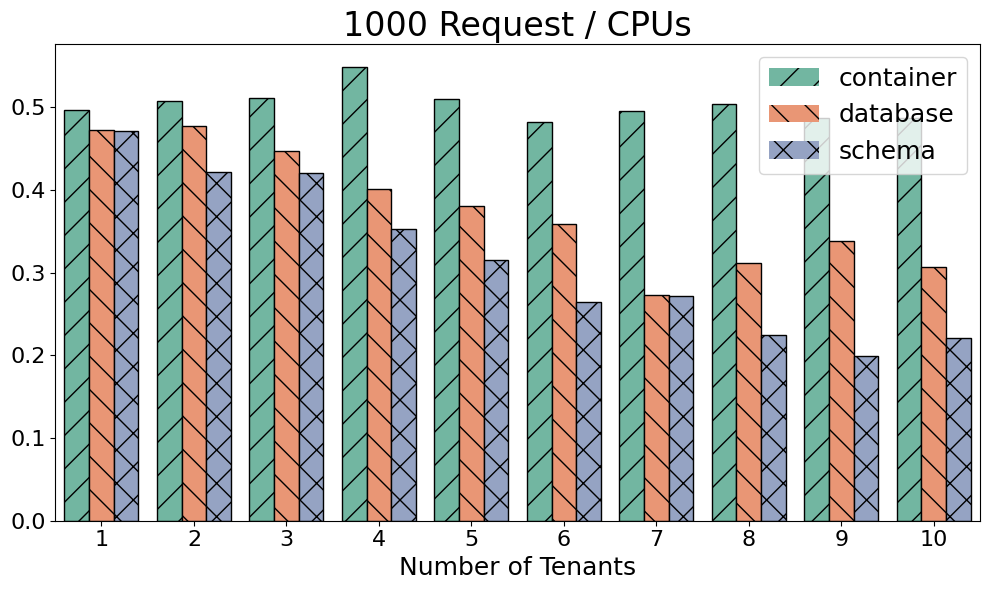

In [31]:
plot_bars(merged_df, y='Request/CPUs', title='1000 Request / CPUs', estimator='max')

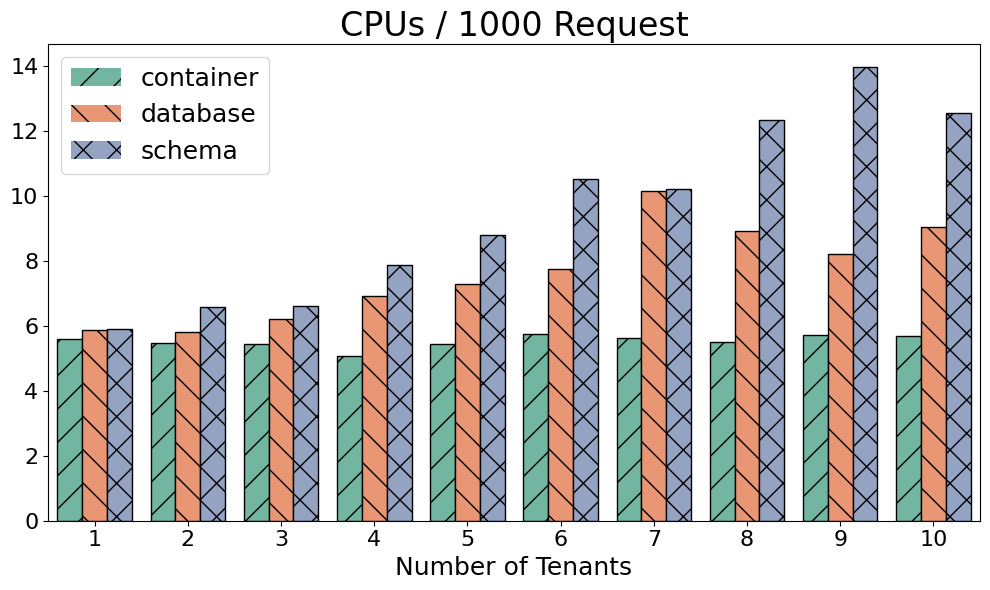

In [32]:
plot_bars(merged_df, y='CPUs/Request', title='CPUs / 1000 Request', estimator='max')

In [33]:
client = '1'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
merged_df['Request/CPUs'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] / 600. * 1000.
merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600. * 1000.

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,Request/CPUs,CPUs/Request
0,1,1609.803135,8,61526.000000,233126,schema,1,1,8295.98,5.22,7.09,18.08,0.323410,8.589021
1,1,1507.044943,11,65703.000000,336237,database,1,1,8099.91,5.22,7.08,20.93,0.310095,8.957828
2,1,1505.636592,8,65801.000000,311428,container,1,1,7932.49,5.18,7.02,16.62,0.316344,8.780882
3,1,1803.913142,9,110006.000000,731973,schema,2,1,10132.37,7.86,11.01,16.65,0.296724,9.361473
4,1,1776.644935,8,111629.000000,777771,database,2,1,9605.15,7.92,11.08,21.43,0.308280,9.010570
5,1,3328.139825,42,59449.000000,330925,container,2,1,18419.05,10.54,14.15,39.06,0.301150,9.223896
6,1,2000.744865,8,148786.000000,1068805,schema,3,1,11515.29,10.63,14.94,31.88,0.289578,9.592502
7,1,2107.141561,10,141317.666667,1060675,database,3,1,11308.67,10.76,15.17,21.96,0.310550,8.944716
8,1,5385.882988,60,55040.333333,244275,container,3,1,28321.29,16.05,21.13,49.70,0.316951,8.764050
9,1,2271.386579,9,174902.750000,1371766,schema,4,1,13469.14,13.74,19.31,31.72,0.281061,9.883199


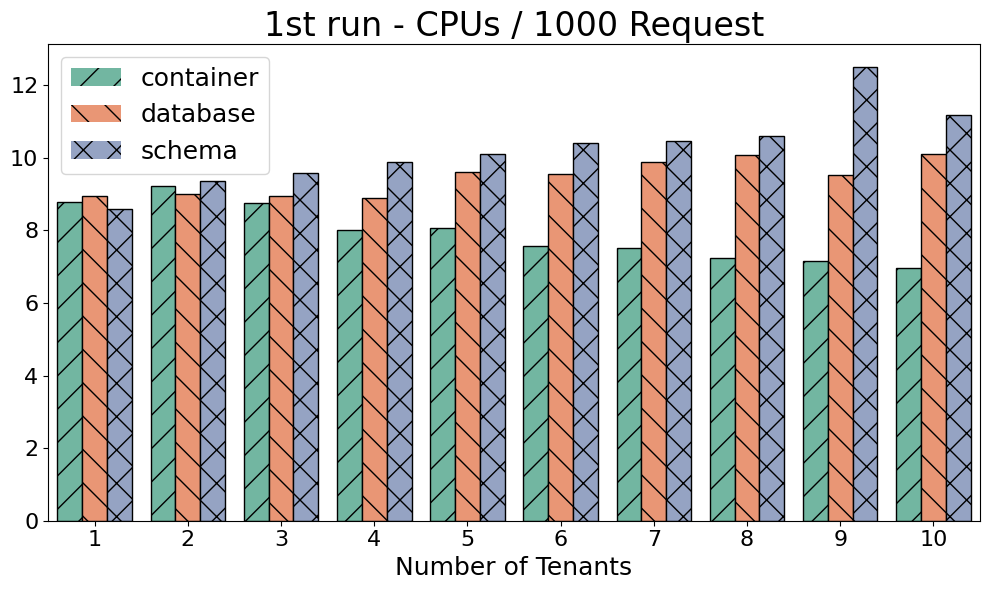

In [34]:
plot_bars(merged_df, y='CPUs/Request', title='1st run - CPUs / 1000 Request', estimator='max')

In [35]:
client = '2'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
merged_df['Request/CPUs'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] / 600. * 1000.
merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600. * 1000.

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,Request/CPUs,CPUs/Request
0,2,3566.358241,44,27644.000000,120050,schema,1,2,12617.86,7.46,11.14,21.51,0.471073,5.896706
1,2,3492.439757,59,28233.000000,121875,database,1,2,12314.01,7.37,10.99,21.49,0.472692,5.876508
2,2,3751.173174,48,26271.000000,110389,container,1,2,12591.02,7.35,11.13,21.38,0.496541,5.594259
3,2,4441.248082,44,44493.000000,170974,schema,2,2,17548.40,10.87,16.17,34.78,0.421809,6.585386
4,2,4597.371346,48,42984.500000,157177,database,2,2,16066.32,11.05,16.46,34.17,0.476916,5.824459
5,2,6993.226286,118,28196.000000,125051,container,2,2,22983.57,14.66,21.01,39.51,0.507118,5.477579
6,2,4333.458057,37,68492.000000,264100,schema,3,2,17185.58,14.02,20.61,39.26,0.420261,6.609648
7,2,4748.354823,54,62545.666667,267435,database,3,2,17711.61,14.21,20.94,39.01,0.446821,6.216753
8,2,8520.776132,148,34676.666667,147900,container,3,2,27784.95,21.04,28.29,47.10,0.511115,5.434746
9,2,4007.228143,24,98843.750000,407453,schema,4,2,18924.13,16.76,24.33,43.84,0.352921,7.870831


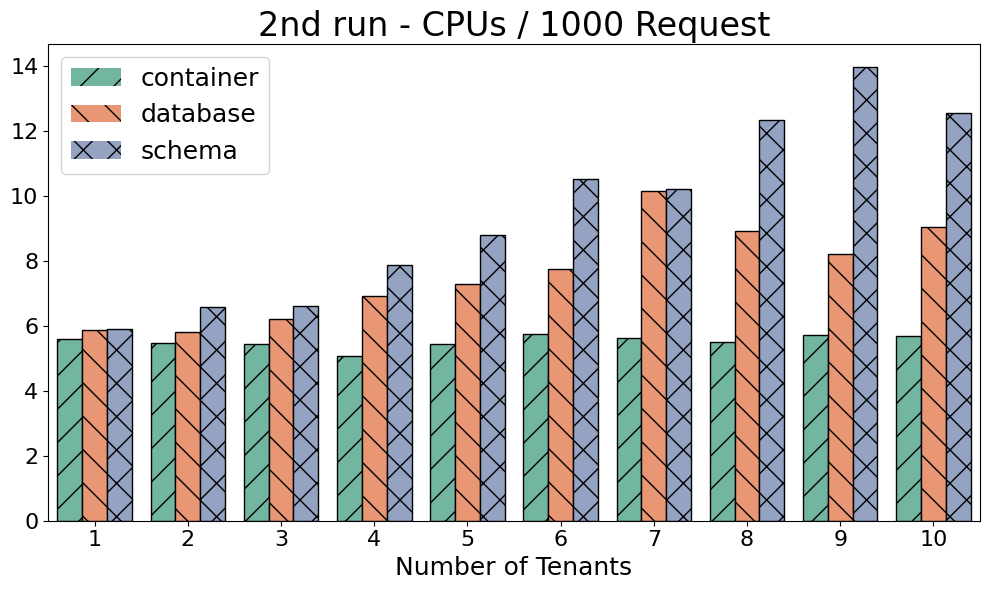

In [36]:
plot_bars(merged_df, y='CPUs/Request', title='2nd run - CPUs / 1000 Request', estimator='max')